In [ ]:
import pandas as pd
benign_df = pd.read_csv("benign_domain_list.csv", header=None)
malicious_df = pd.read_csv("Malicious_URLs.csv")
mixed_df = pd.read_csv("mixed_domain_list.csv", header=None)
tranco_df = pd.read_csv("tranco_full_list_for_ranking.csv", header=None)
tld_scores_df = pd.read_csv('Spamhaus-tlds.csv')

In [ ]:
benign_df

In [ ]:
malicious_df

In [ ]:
mixed_df

In [ ]:
tranco_df

In [ ]:
# Block for installs
%pip install dnstwist
%pip install newspaper3k
%pip install requests
%pip install beautifulsoup4

In [ ]:
### Defining methods block
from urllib.parse import urlparse
import tldextract
import dnstwist
from newspaper import Article, Config
import newspaper
import requests
from bs4 import BeautifulSoup

def calculate_percentage_digits(domain):
    digits_count = sum(c.isdigit() for c in domain)
    total_chars = len(domain)
    percentage_digits = digits_count / total_chars * 100
    return percentage_digits

def get_fqdn(url):
    parsed_url = urlparse(url)
    return parsed_url.netloc

def count_unique_chars(domain):
    unique_chars = set(domain)
    return len(unique_chars) - 1     ### -1 because it counts the '.' in the FQDN

def count_hyphens(domain):
    hyphens_count = sum(c == '-' for c in domain)
    return hyphens_count

def count_dots(domain):
    dot_count = sum(c == '.' for c in domain)
    return dot_count

def get_tld(domain):
    ext = tldextract.extract(domain)
    return ext.suffix

def dnstwist_results(domain):
    results = dnstwist.Fuzzer(domain)
    return results.generate()

def generate_potential_typosquatting_domains(domain):
    fuzzer = dnstwist.Fuzzer(domain)
    variations = fuzzer.generate(max_changes=2, max_additions=2, max_deletions=2)
    if variations is not None:
        return set(variation.domain for variation in variations)
    else:
        return set()

In [ ]:
benign_df['Domain'] = benign_df[0]
benign_df['Domain Length'] = benign_df[0].str.len()
benign_df['Digit Percentage'] = benign_df[0].apply(calculate_percentage_digits)
benign_df['Unique Character Count'] = benign_df[0].apply(count_unique_chars)
benign_df['Hypen Count'] = benign_df[0].apply(count_hyphens)
benign_df['Dot Count'] = benign_df[0].apply(count_dots)
benign_df['TLD'] = benign_df[0].apply(get_tld)
#benign_df['DNSTwist Results'] = benign_df[0].apply(dnstwist_results)
merged_benign_tldscores_df = pd.merge(benign_df, tld_scores_df, on='TLD', how='left')
benign_df['TLD Reputation Score'] = merged_benign_tldscores_df['score']
benign_df['Tranco Rank'] = benign_df['Domain'].map(tranco_df.set_index('Domain')[0])
benign_df

In [21]:
malicious_df['Domain'] = malicious_df['url'].apply(get_fqdn)
malicious_df['Domain Length'] = malicious_df['Domain'].str.len()
malicious_df['Digit Percentage'] = malicious_df['Domain'].apply(calculate_percentage_digits)
malicious_df['Digit Count'] = malicious_df['Domain'].apply(count_unique_chars)
malicious_df['Hyphen Count'] = malicious_df['Domain'].apply(count_hyphens)
malicious_df['Dot Count'] = malicious_df['Domain'].apply(count_dots)
malicious_df['Tranco Rank'] = malicious_df['Domain'].map(tranco_df.set_index('Domain')[0]) #not working correctly
malicious_df['TLD'] = malicious_df['Domain'].apply(get_tld)
merged_mal_tldscores_df = pd.merge(malicious_df, tld_scores_df, on='TLD', how='left')
malicious_df['TLD Reputation Score'] = merged_mal_tldscores_df['score']
malicious_df

,url,Domain,Domain Length,Digit Percentage,Digit Count,Hyphen Count,Dot Count,Tranco Rank,TLD,TLD Reputation Score
0,https://ervashipping.com/,ervashipping.com,16,0.000000,13,0,1,NaN,com,0.18
1,http://www.gabung-grupmabarcimbrut.duckdns.org/,www.gabung-grupmabarcimbrut.duckdns.org,39,0.000000,17,1,3,NaN,org,0.07
2,http://republik-jancuk.000webhostapp.com/,republik-jancuk.000webhostapp.com,33,9.090909,20,1,2,NaN,com,0.18
3,https://www.chet-notnkt8-grup.duckdns.org/,www.chet-notnkt8-grup.duckdns.org,33,3.030303,16,2,3,NaN,org,0.07
4,http://veromcertiom.ddns.net/connexion/certico...,veromcertiom.ddns.net,21,0.000000,11,0,2,NaN,net,0.13
...,...,...,...,...,...,...,...,...,...,...
10624,http://sites.google.com/site/habbotuttogratis,sites.google.com,16,0.000000,9,0,2,NaN,com,0.18
10625,http://www.habbocreditosparati.blogspot.com/,www.habbocreditosparati.blogspot.com,36,0.000000,16,0,3,NaN,com,0.18
10626,http://creditiperhabbogratissicuro100.blogspot...,creditiperhabbogratissicuro100.blogspot.com,43,6.976744,18,0,2,NaN,com,0.18
10627,http://mundovirtualhabbo.blogspot.com/2009_01_...,mundovirtualhabbo.blogspot.com,30,0.000000,17,0,2,NaN,com,0.18


In [22]:

mixed_df['Domain'] = mixed_df[0]
mixed_df['Domain Length'] = mixed_df[0].str.len()
mixed_df['Digit Percentage'] = mixed_df[0].apply(calculate_percentage_digits)
mixed_df['Digit Count'] = mixed_df[0].apply(count_unique_chars)
mixed_df['Hypen Count'] = mixed_df[0].apply(count_hyphens)
mixed_df['Dot Count'] = mixed_df[0].apply(count_dots)
mixed_df['Tranco Rank'] = mixed_df['Domain'].map(tranco_df.set_index('Domain')[0])
mixed_df['TLD'] = mixed_df[0].apply(get_tld)
merged_mixed_tldscores_df = pd.merge(mixed_df, tld_scores_df, on='TLD', how='left')
mixed_df['TLD Reputation Score'] = merged_mixed_tldscores_df['score']
mixed_df

,0,Domain,Domain Length,Digit Percentage,Digit Count,Hypen Count,Dot Count,Tranco Rank,TLD,TLD Reputation Score
0,goodrx.com,goodrx.com,10,0.000000,7,0,1,3509.0,com,0.18
1,weather.com.cn,weather.com.cn,14,0.000000,10,0,2,3524.0,com.cn,NaN
2,draftkings.com,draftkings.com,14,0.000000,13,0,1,3470.0,com,0.18
3,suntimes.com,suntimes.com,12,0.000000,9,0,1,3523.0,com,0.18
4,moe.gov.cn,moe.gov.cn,10,0.000000,7,0,2,3519.0,gov.cn,NaN
...,...,...,...,...,...,...,...,...,...,...
178,services.runescape.com-ul.cc,services.runescape.com-ul.cc,28,0.000000,14,1,3,NaN,cc,0.16
179,nsu-amazon.1inc.top,nsu-amazon.1inc.top,19,5.263158,13,1,2,NaN,top,1.64
180,80fxv9.cn,80fxv9.cn,9,33.333333,8,0,1,NaN,cn,0.97
181,nsu-amazon.3inc.top,nsu-amazon.3inc.top,19,5.263158,13,1,2,NaN,top,1.64


In [ ]:
tranco_df['Domain'] = tranco_df[1]
tranco_df['Domain Length'] = tranco_df[1].str.len()
tranco_df['Digit Percentage'] = tranco_df[1].apply(calculate_percentage_digits)
tranco_df['Digit Count'] = tranco_df[1].apply(count_unique_chars)
tranco_df['Hypen Count'] = tranco_df[1].apply(count_hyphens)
tranco_df['Dot Count'] = tranco_df[1].apply(count_dots)
tranco_df

Avg Benign Domain Length:  11.538787023977433
Average Malicious Domain Length:  21.79951077241509


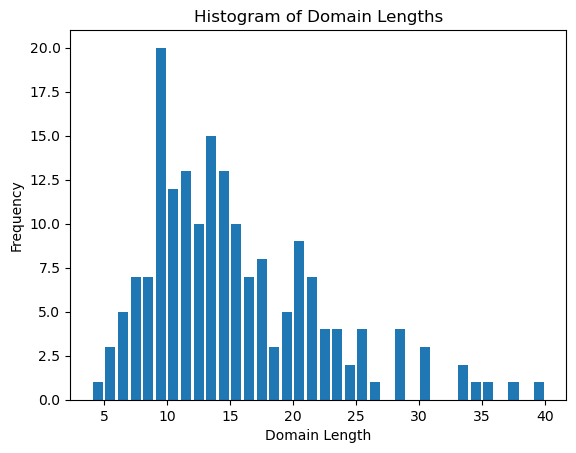

In [29]:
import matplotlib.pyplot as plt


# Average amounts for different Characteristics

benign_domain_lengths = benign_df['Domain'].apply(lambda x: len(x))
benign_avg_domain_length = benign_domain_lengths.mean()
print("Avg Benign Domain Length: ", benign_avg_domain_length)


malicious_domain_lengths = malicious_df['Domain'].apply(lambda x: len(x))
malicious_df_avg_domain_length = malicious_domain_lengths.mean()
print("Average Malicious Domain Length: ", malicious_df_avg_domain_length)


mixed_domain_lengths = mixed_df['Domain'].apply(lambda x: len(x))
mixed_domain_lengths.plot(kind='hist', bins=range(min(mixed_domain_lengths), max(mixed_domain_lengths) + 2), rwidth=0.8)
plt.xlabel('Domain Length')
plt.title('Histogram of Domain Lengths')
plt.show()
